# Fase 4: Modelado y Evaluación (El "Torneo")

## 1\. Objetivo

Esta es la Fase 4. Habiendo completado el ETL en la Fase 3, nuestro objetivo es:

1.  **Pre-procesar** el dataset limpio (traducir palabras a números) usando un pipeline profesional.
2.  **Entrenar** un "Torneo" de 7 modelos de clasificación (incluyendo una Red Neuronal).
3.  **Evaluar** cada modelo usando las métricas correctas (enfocadas en el desbalance).
4.  **Elegir** el mejor modelo para nuestra Fase 5 (Guardado) y Fase 6 (Streamlit).

## 2\. Configuración Inicial

### 2.1. Importar Librerías

Necesitaremos `pandas` para cargar y `scikit-learn` para todo el modelado.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# --- Pre-procesamiento ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline # ¡La herramienta clave!

# --- Modelos (Nuestro "Torneo" Expandido) ---
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # (Nuevo)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB # (Nuevo)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier # (Nuevo)
from lightgbm import LGBMClassifier # (Nuevo)
from catboost import CatBoostClassifier # (Nuevo)
from sklearn.neural_network import MLPClassifier

# --- Evaluación (Métricas y Gráficos) ---
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    recall_score,
    precision_score, # (Nuevo)
    f1_score, # (Nuevo)
    roc_auc_score, # (Nuevo - ¡Corrige el NameError!)
    average_precision_score, # (Nuevo - Para PR-AUC)
    RocCurveDisplay, # (Nuevo - Para gráficos)
    PrecisionRecallDisplay, # (Nuevo - Para gráficos)
    ConfusionMatrixDisplay # (Nuevo - Para gráficos)
)

### 2.2. Cargar Datos Limpios (Producto de Fase 3)

Cargamos el "lingote de oro" que produjimos en la Fase 3.

In [3]:
# Definir la ruta de entrada
INPUT_PATH = "../data/processed/mvp_dataset_fase3_limpio.csv"

try:
    df = pd.read_csv(INPUT_PATH)
    print(f"Dataset limpio cargado exitosamente: {df.shape}")
    print(f"Distribución del Target en el dataset completo:")
    print(df['Desnutricion_Cronica'].value_counts(normalize=True))
except FileNotFoundError:
    print(f"ERROR: No se encontró el archivo en {INPUT_PATH}")
except Exception as e:
    print(f"Error al cargar el archivo: {e}")

Dataset limpio cargado exitosamente: (17698, 13)
Distribución del Target en el dataset completo:
Desnutricion_Cronica
0    0.882812
1    0.117188
Name: proportion, dtype: float64


## 3\. PARTE 1: Pre-procesamiento (El "Traductor")

### 3.1. Definir `X` (Predictores) e `y` (Target)

Separamos nuestro objetivo (`Desnutricion_Cronica`) de nuestros 8 predictores clave.

In [4]:
# --- 'y' (Target) ---
TARGET = 'Desnutricion_Cronica'
y = df[TARGET]

# --- 'X' (Predictores) ---
# Seleccionamos solo las 8 columnas predictoras finales
PREDICTORS = [
    'edad_meses',
    'peso_nacer_kg',
    'talla_madre_cm',
    'zona',
    'agua',
    'saneamiento',
    'riqueza',
    'educacion_madre'
]
X = df[PREDICTORS]

print(f"Forma de X (predictores): {X.shape}")
print(f"Forma de y (target): {y.shape}")

Forma de X (predictores): (17698, 8)
Forma de y (target): (17698,)


### 3.2. Construir el "Traductor" (ColumnTransformer)

Aquí definimos qué "adaptador" (transformador) se aplica a qué columna.

In [5]:
# 1. Identificar nuestras columnas por tipo
numeric_features = [
    'edad_meses',
    'peso_nacer_kg',
    'talla_madre_cm'
]

# (!!!) Usaremos OneHotEncoder para TODAS las categóricas.
categorical_features = [
    'zona',
    'agua',
    'saneamiento',
    'riqueza',
    'educacion_madre'
]

# 2. Definir los "adaptadores"
# Adaptador para números: Estandarizar (escalar). Obligatorio para Redes Neuronales y SVM.
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Adaptador para palabras: One-Hot Encoding
# handle_unknown='ignore' -> si en el futuro ve una categoría nueva, la ignora
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 3. Construir la "Caja de Adaptadores" (ColumnTransformer)
# Esta herramienta aplica el transformador correcto a la columna correcta.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # No dejar pasar nada que no hayamos definido
)

print("Traductor (ColumnTransformer) construido exitosamente.")

Traductor (ColumnTransformer) construido exitosamente.


### 3.3. Dividir los Datos (Train/Test Split)

Dividimos nuestros 17,698 niños en un grupo de entrenamiento y un grupo de prueba.
`stratify=y` es **crucial**: asegura que el `11.7%` de desnutridos se mantenga tanto en el set de entrenamiento como en el de prueba.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2, # 20% para pruebas (aprox. 3540 niños)
    random_state=42, # Para reproducibilidad
    stratify=y # ¡MUY IMPORTANTE para datos desbalanceados!
)

print(f"Datos de Entrenamiento: {X_train.shape[0]} filas")
print(f"Datos de Prueba: {X_test.shape[0]} filas")
print(f"\nDistribución del Target en Entrenamiento (y_train):\n{y_train.value_counts(normalize=True)}")
print(f"\nDistribución del Target en Prueba (y_test):\n{y_test.value_counts(normalize=True)}")

Datos de Entrenamiento: 14158 filas
Datos de Prueba: 3540 filas

Distribución del Target en Entrenamiento (y_train):
Desnutricion_Cronica
0    0.882822
1    0.117178
Name: proportion, dtype: float64

Distribución del Target en Prueba (y_test):
Desnutricion_Cronica
0    0.882768
1    0.117232
Name: proportion, dtype: float64


1. <b>División 80/20:</b> Tenemos 14,158 filas para "entrenar" (80%) y 3,540 para "probar" (20%), lo cual es un balance estándar.

2. <b>Estratificación `(stratify=y)` Exitosa:</b> Este es el punto crítico. La proporción de nuestro target (el 11.7% de niños con desnutrición) es casi idéntica en ambos grupos (Entrenamiento y Prueba).

## 4\. PARTE 2: El "Torneo" de Modelos

Ahora, creamos una "línea de ensamblaje" (Pipeline) para cada modelo, que automáticamente "traduce" (pre-procesa) los datos antes de "entrenar".

### 4.1. Definir los Contendientes


In [7]:
# (!!!) class_weight='balanced' es CLAVE para manejar el desbalance
# Lo aplicamos en los modelos que lo soportan.
models = {
    "Regresión Logística": LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000, n_jobs=-1),
    "LDA": LinearDiscriminantAnalysis(),
    "Support Vector Machine (SVM)": SVC(random_state=42, class_weight='balanced', probability=True),
    "K-Nearest Neighbors (KNN)": KNeighborsClassifier(n_jobs=-1),
    "Naive Bayes": GaussianNB(),
    "Árbol de Decisión": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()), # (Param p/ desbalance)
    "LightGBM": LGBMClassifier(random_state=42, class_weight='balanced'),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=False, auto_class_weights='Balanced'), # (Manejo de desbalance nativo)
    "Red Neuronal (MLP)": MLPClassifier(random_state=42, max_iter=500, early_stopping=True, activation='relu', hidden_layer_sizes=(50, 25)),
}

### 4.2. Ejecutar el Torneo y Evaluar

Iteramos sobre cada modelo, lo conectamos a nuestro "Traductor" (preprocessor), lo entrenamos y vemos los resultados.

In [9]:
# Almacenaremos los resultados aquí
results = {}

# Definimos las etiquetas para el reporte de clasificación
target_names = ['No Desnutrido (0)', 'SÍ Desnutrido (1)']

for model_name, model in models.items():

    print(f"--- Entrenando: {model_name} ---")
    start_time = time.time()

    # 1. Crear el Pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # 2. Entrenar
    # (CatBoost a veces necesita que los datos no sean 'sparse' tras el OHE)
    # (Pero nuestro OHE ya tiene sparse_output=False, así que estamos bien)
    pipeline.fit(X_train, y_train)

    # 3. Predecir
    y_pred = pipeline.predict(X_test)

    # Obtener probabilidades (Clave para ROC-AUC y PR-AUC)
    # Algunos modelos (como LDA sin 'solver') o SVM sin probability=True podrían no tenerlo
    if hasattr(pipeline, "predict_proba"):
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1] # Probabilidad de la clase "1"
    else:
        # Si no hay predict_proba, usamos las predicciones para AUC (menos ideal)
        try:
            y_pred_proba = pipeline.decision_function(X_test)
            # Normalizar si no está entre 0 y 1
            if y_pred_proba.min() < 0:
                 y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())
        except AttributeError:
             y_pred_proba = y_pred # (Último recurso)

    # 4. Evaluar (¡Capturamos TODAS las métricas ahora!)
    accuracy = accuracy_score(y_test, y_pred)
    recall_clase_1 = recall_score(y_test, y_pred, pos_label=1)
    precision_clase_1 = precision_score(y_test, y_pred, pos_label=1)
    f1_clase_1 = f1_score(y_test, y_pred, pos_label=1)

    # (Evitar error si el modelo no pudo predecir probabilidades)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 0.0
    pr_auc = average_precision_score(y_test, y_pred_proba) if y_pred_proba is not None else 0.0

    reporte_texto = classification_report(y_test, y_pred, target_names=target_names)

    end_time = time.time()
    training_time = end_time - start_time

    # 5. Guardar Resultados Completos
    results[model_name] = {
        "Pipeline": pipeline,
        "Accuracy": accuracy,
        "Recall (Clase 1)": recall_clase_1,
        "Precision (Clase 1)": precision_clase_1,
        "F1-Score (Clase 1)": f1_clase_1,
        "ROC-AUC": roc_auc,
        "PR-AUC (Avg_Precision)": pr_auc,
        "Tiempo (seg)": training_time,
        "Reporte_Texto": reporte_texto,
        "y_pred": y_pred,
        "y_pred_proba": y_pred_proba
    }

    print(f"Tiempo de entrenamiento: {training_time:.2f} segundos")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"(!!!) RECALL CLASE 1 (SÍ Desnutrido): {recall_clase_1:.4f}")
    print(f"F1-Score CLASE 1: {f1_clase_1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(reporte_texto)
    print("="*60 + "\n")

print("¡Torneo completado!")

--- Entrenando: Regresión Logística ---
Tiempo de entrenamiento: 2.21 segundos
Accuracy: 0.7147
(!!!) RECALL CLASE 1 (SÍ Desnutrido): 0.7012
F1-Score CLASE 1: 0.3656
ROC-AUC: 0.7749
                   precision    recall  f1-score   support

No Desnutrido (0)       0.95      0.72      0.82      3125
SÍ Desnutrido (1)       0.25      0.70      0.37       415

         accuracy                           0.71      3540
        macro avg       0.60      0.71      0.59      3540
     weighted avg       0.87      0.71      0.76      3540


--- Entrenando: LDA ---
Tiempo de entrenamiento: 0.11 segundos
Accuracy: 0.8856
(!!!) RECALL CLASE 1 (SÍ Desnutrido): 0.1084
F1-Score CLASE 1: 0.1818
ROC-AUC: 0.7727
                   precision    recall  f1-score   support

No Desnutrido (0)       0.89      0.99      0.94      3125
SÍ Desnutrido (1)       0.56      0.11      0.18       415

         accuracy                           0.89      3540
        macro avg       0.73      0.55      0.56      35

/Users/abelguevarah/Desktop/md-project-i/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [15:19:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tiempo de entrenamiento: 0.40 segundos
Accuracy: 0.7856
(!!!) RECALL CLASE 1 (SÍ Desnutrido): 0.4964
F1-Score CLASE 1: 0.3518
ROC-AUC: 0.7496
                   precision    recall  f1-score   support

No Desnutrido (0)       0.92      0.82      0.87      3125
SÍ Desnutrido (1)       0.27      0.50      0.35       415

         accuracy                           0.79      3540
        macro avg       0.60      0.66      0.61      3540
     weighted avg       0.85      0.79      0.81      3540


--- Entrenando: LightGBM ---
[LightGBM] [Info] Number of positive: 1659, number of negative: 12499
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 14158, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0

/Users/abelguevarah/Desktop/md-project-i/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/abelguevarah/Desktop/md-project-i/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Tiempo de entrenamiento: 0.22 segundos
Accuracy: 0.7531
(!!!) RECALL CLASE 1 (SÍ Desnutrido): 0.6337
F1-Score CLASE 1: 0.3757
ROC-AUC: 0.7801
                   precision    recall  f1-score   support

No Desnutrido (0)       0.94      0.77      0.85      3125
SÍ Desnutrido (1)       0.27      0.63      0.38       415

         accuracy                           0.75      3540
        macro avg       0.60      0.70      0.61      3540
     weighted avg       0.86      0.75      0.79      3540


--- Entrenando: CatBoost ---
Tiempo de entrenamiento: 5.03 segundos
Accuracy: 0.7655
(!!!) RECALL CLASE 1 (SÍ Desnutrido): 0.6072
F1-Score CLASE 1: 0.3778
ROC-AUC: 0.7761
                   precision    recall  f1-score   support

No Desnutrido (0)       0.94      0.79      0.86      3125
SÍ Desnutrido (1)       0.27      0.61      0.38       415

         accuracy                           0.77      3540
        macro avg       0.61      0.70      0.62      3540
     weighted avg       0.86    

## 5\. PARTE 3: Elegir al Ganador

### 5.1. Tabla de Resultados del Torneo

In [12]:
# Convertir los resultados a un DataFrame para fácil comparación
results_df = pd.DataFrame(results).T

# Seleccionamos las columnas más importantes para mostrar
columnas_display = [
    'Recall (Clase 1)',
    'F1-Score (Clase 1)',
    'Precision (Clase 1)',
    'ROC-AUC',
    'PR-AUC (Avg_Precision)',
    'Accuracy',
    'Tiempo (seg)'
]

# Creamos el dataframe solo con esas columnas para mostrarlo
results_display_df = results_df[columnas_display].apply(pd.to_numeric, errors='ignore')

# Ordenamos por la métrica meta (p.ej. F1-Score o ROC-AUC)
# ¡Tus metas son altas (F1 >= 0.75, ROC-AUC >= 0.85)!
results_display_df = results_display_df.sort_values(by="F1-Score (Clase 1)", ascending=False)

print("--- Tabla de Resultados del Torneo ---")
print("(Ordenado por F1-Score de la Clase 1)")

# Aplicar formato para mejor lectura
print(results_display_df.to_markdown(floatfmt=".4f"))

--- Tabla de Resultados del Torneo ---
(Ordenado por F1-Score de la Clase 1)
|                              |   Recall (Clase 1) |   F1-Score (Clase 1) |   Precision (Clase 1) |   ROC-AUC |   PR-AUC (Avg_Precision) |   Accuracy |   Tiempo (seg) |
|:-----------------------------|-------------------:|---------------------:|----------------------:|----------:|-------------------------:|-----------:|---------------:|
| CatBoost                     |             0.6072 |               0.3778 |                0.2742 |    0.7761 |                   0.3240 |     0.7655 |         5.0293 |
| Support Vector Machine (SVM) |             0.6964 |               0.3773 |                0.2587 |    0.7745 |                   0.3081 |     0.7305 |        69.0594 |
| LightGBM                     |             0.6337 |               0.3757 |                0.2670 |    0.7801 |                   0.3233 |     0.7531 |         0.2242 |
| Regresión Logística          |             0.7012 |               0.365

/var/folders/1t/__6zthl15118ydy36mkxn2980000gn/T/ipykernel_69109/3393561024.py:16: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  results_display_df = results_df[columnas_display].apply(pd.to_numeric, errors='ignore')


#### 5.2.1. Matrices de Confusión

--- Matrices de Confusión (Top 4 Modelos por F1-Score) ---


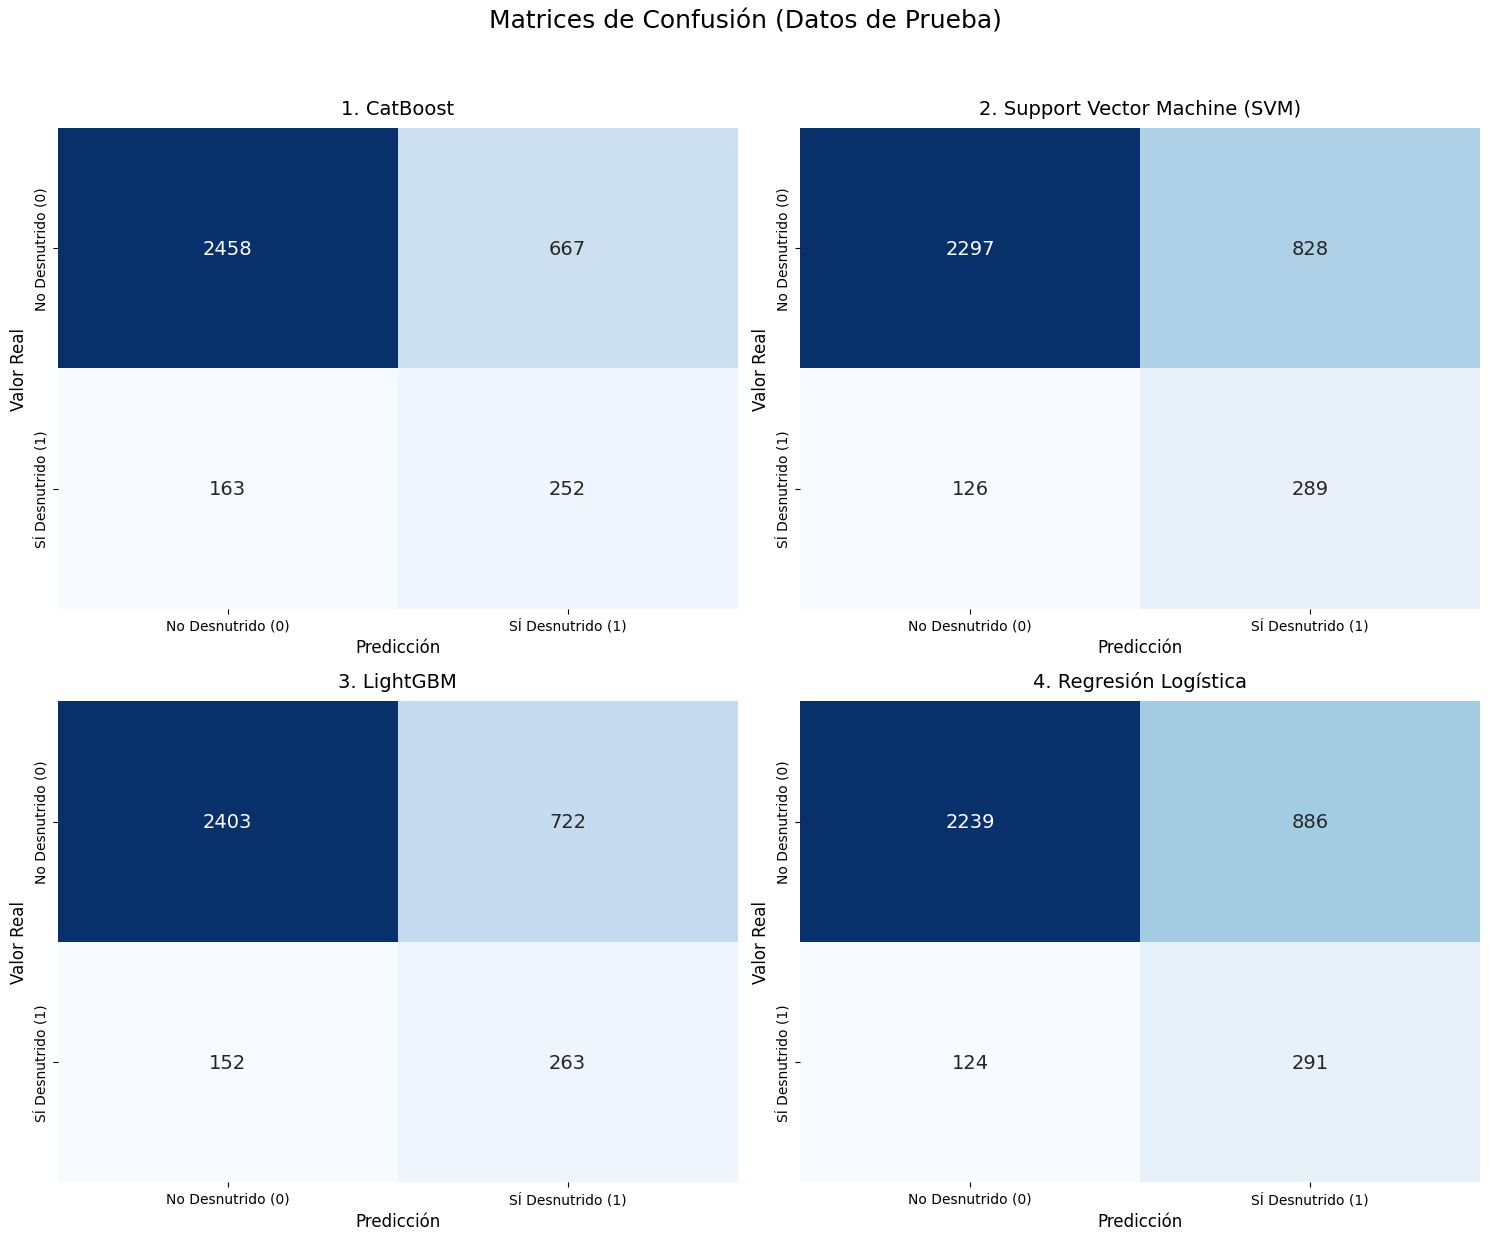

In [13]:
# Matrices de Confusión

print("--- Matrices de Confusión (Top 4 Modelos por F1-Score) ---")

# Tomamos el orden del dataframe que ya ordenamos
top_4_models = results_display_df.index[:4]

plt.figure(figsize=(15, 12))
plt.suptitle("Matrices de Confusión (Datos de Prueba)", fontsize=18, y=1.03)

for i, model_name in enumerate(top_4_models):
    ax = plt.subplot(2, 2, i + 1)

    # Extraer las predicciones guardadas
    y_pred = results[model_name]["y_pred"]
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=target_names, yticklabels=target_names,
                cbar=False, annot_kws={"size": 14})

    ax.set_title(f"{i+1}. {model_name}", fontsize=14, pad=10)
    ax.set_xlabel('Predicción', fontsize=12)
    ax.set_ylabel('Valor Real', fontsize=12)

plt.tight_layout()
plt.show()

#### 5.2.2. Curvas ROC-AUC y PR-AUC

--- Curvas de Evaluación (Todos los Modelos) ---


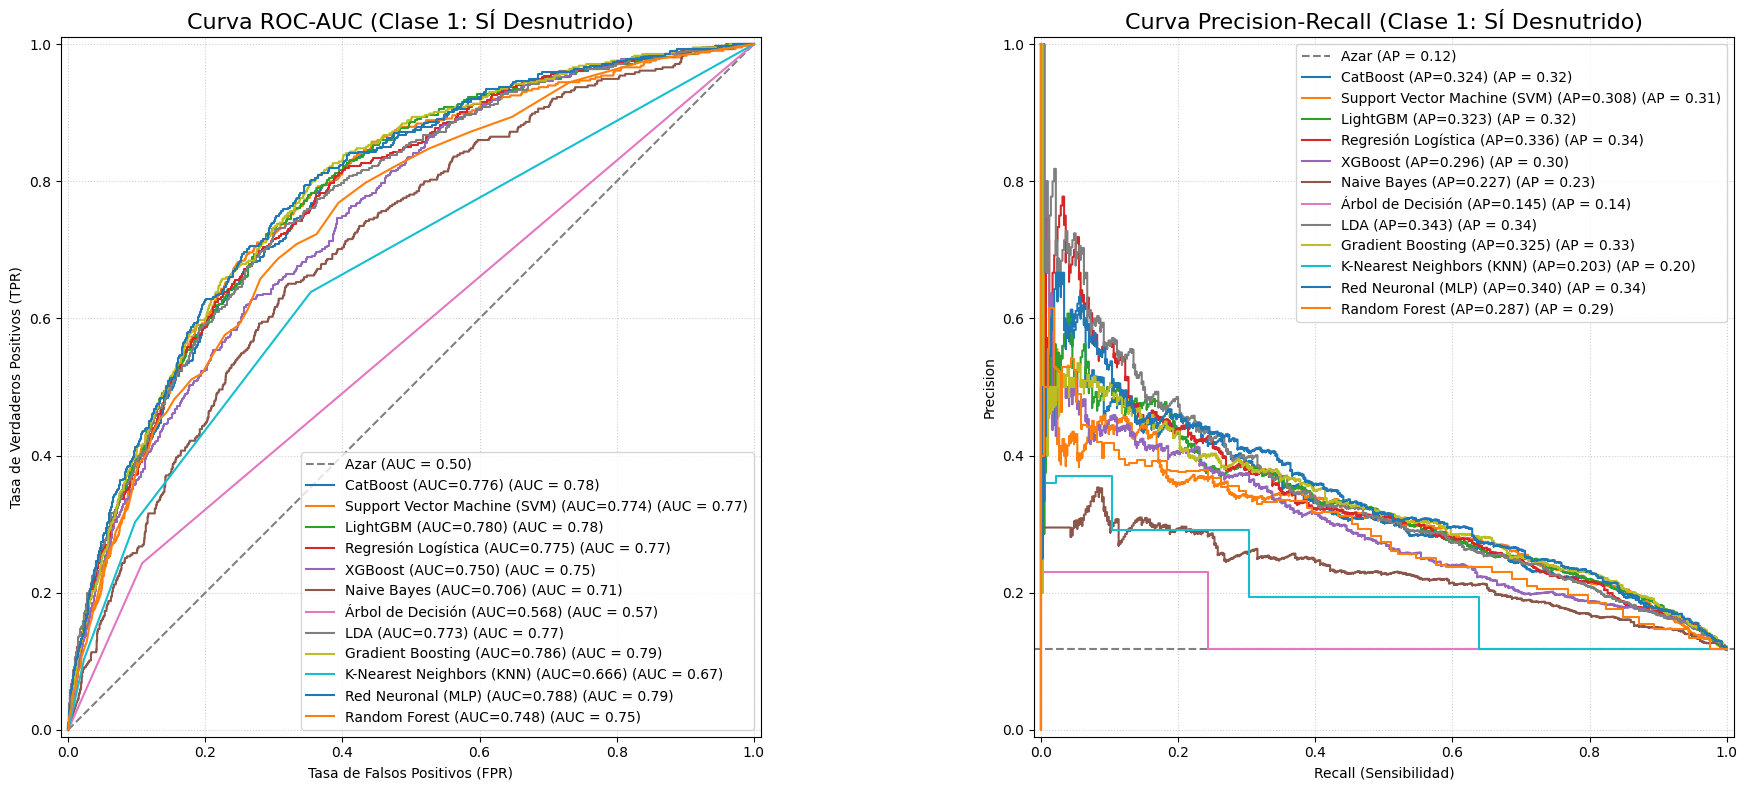

In [14]:
# Curvas ROC-AUC y PR-AUC

print("--- Curvas de Evaluación (Todos los Modelos) ---")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# --- Gráfico 1: Curva ROC-AUC ---
# (Mide qué tan bueno es el modelo separando clases)
ax1.set_title("Curva ROC-AUC (Clase 1: SÍ Desnutrido)", fontsize=16)
ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Azar (AUC = 0.50)') # Línea de azar

# --- Gráfico 2: Curva PR-AUC ---
# (Métrica clave para datos desbalanceados)
ax2.set_title("Curva Precision-Recall (Clase 1: SÍ Desnutrido)", fontsize=16)
# Proporción de positivos (baseline)
baseline_pr = (y_test == 1).sum() / len(y_test)
ax2.axhline(baseline_pr, linestyle='--', color='gray', label=f'Azar (AP = {baseline_pr:.2f})')


# Iteramos y dibujamos las curvas para cada modelo
for model_name in results_display_df.index: # Usamos el orden de F1
    data = results[model_name]

    # Solo graficar si tenemos probabilidades válidas
    if data['y_pred_proba'] is not None and not isinstance(data['y_pred_proba'], (str, int)):

        # 1. ROC
        RocCurveDisplay.from_predictions(
            y_test,
            data['y_pred_proba'],
            name=f"{model_name} (AUC={data['ROC-AUC']:.3f})",
            ax=ax1,
            pos_label=1
        )

        # 2. PR
        PrecisionRecallDisplay.from_predictions(
            y_test,
            data['y_pred_proba'],
            name=f"{model_name} (AP={data['PR-AUC (Avg_Precision)']:.3f})",
            ax=ax2,
            pos_label=1
        )

ax1.legend(loc='lower right', prop={'size': 10})
ax1.set_xlabel("Tasa de Falsos Positivos (FPR)")
ax1.set_ylabel("Tasa de Verdaderos Positivos (TPR)")
ax1.grid(True, linestyle=':', alpha=0.6)

ax2.legend(loc='upper right', prop={'size': 10})
ax2.set_xlabel("Recall (Sensibilidad)")
ax2.set_ylabel("Precision")
ax2.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

### 5.3. Preparación para el "Round 2": SMOTE

In [17]:
# (!!!) Importamos las herramientas de imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline # Pipeline especial que maneja SMOTE

# Almacenaremos los NUEVOS resultados aquí
results_smote = {}

# Definimos las etiquetas
target_names = ['No Desnutrido (0)', 'SÍ Desnutrido (1)']

# El diccionario 'models' ya debería estar definido de la celda 4.1
# Si no, puedes copiarlo aquí.

for model_name, model in models.items():

    print(f"--- Entrenando (Round 2 con SMOTE): {model_name} ---")
    start_time = time.time()

    # 1. Crear el Pipeline (!!!) CON SMOTE
    # Usamos ImbPipeline para que SMOTE se aplique ANTES del clasificador
    pipeline_smote = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)), # <-- ¡EL CAMBIO CLAVE!
        ('classifier', model)
    ])

    # 2. Entrenar
    pipeline_smote.fit(X_train, y_train)

    # 3. Predecir
    y_pred = pipeline_smote.predict(X_test)

    # Obtener probabilidades
    if hasattr(pipeline_smote, "predict_proba"):
        y_pred_proba = pipeline_smote.predict_proba(X_test)[:, 1]
    else:
        try:
            y_pred_proba = pipeline_smote.decision_function(X_test)
            if y_pred_proba.min() < 0:
                 y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())
        except AttributeError:
             y_pred_proba = y_pred

    # 4. Evaluar (Capturamos todas las métricas)
    accuracy = accuracy_score(y_test, y_pred)
    recall_clase_1 = recall_score(y_test, y_pred, pos_label=1)
    precision_clase_1 = precision_score(y_test, y_pred, pos_label=1)
    f1_clase_1 = f1_score(y_test, y_pred, pos_label=1)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 0.0
    pr_auc = average_precision_score(y_test, y_pred_proba) if y_pred_proba is not None else 0.0
    reporte_texto = classification_report(y_test, y_pred, target_names=target_names)

    end_time = time.time()
    training_time = end_time - start_time

    # 5. Guardar Resultados (en el nuevo diccionario)
    results_smote[model_name] = {
        "Pipeline": pipeline_smote,
        "Accuracy": accuracy,
        "Recall (Clase 1)": recall_clase_1,
        "Precision (Clase 1)": precision_clase_1,
        "F1-Score (Clase 1)": f1_clase_1,
        "ROC-AUC": roc_auc,
        "PR-AUC (Avg_Precision)": pr_auc,
        "Tiempo (seg)": training_time,
        "Reporte_Texto": reporte_texto,
        "y_pred": y_pred,
        "y_pred_proba": y_pred_proba
    }

    print(f"Tiempo de entrenamiento: {training_time:.2f} segundos")
    print(f"(!!!) RECALL CLASE 1 (SÍ Desnutrido): {recall_clase_1:.4f}")
    print(f"F1-Score CLASE 1: {f1_clase_1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(reporte_texto)
    print("="*60 + "\n")

print("¡Torneo (Round 2 con SMOTE) completado!")

--- Entrenando (Round 2 con SMOTE): Regresión Logística ---
Tiempo de entrenamiento: 3.12 segundos
(!!!) RECALL CLASE 1 (SÍ Desnutrido): 0.6747
F1-Score CLASE 1: 0.3526
ROC-AUC: 0.7694
                   precision    recall  f1-score   support

No Desnutrido (0)       0.94      0.71      0.81      3125
SÍ Desnutrido (1)       0.24      0.67      0.35       415

         accuracy                           0.71      3540
        macro avg       0.59      0.69      0.58      3540
     weighted avg       0.86      0.71      0.76      3540


--- Entrenando (Round 2 con SMOTE): LDA ---
Tiempo de entrenamiento: 0.28 segundos
(!!!) RECALL CLASE 1 (SÍ Desnutrido): 0.6795
F1-Score CLASE 1: 0.3512
ROC-AUC: 0.7688
                   precision    recall  f1-score   support

No Desnutrido (0)       0.94      0.71      0.81      3125
SÍ Desnutrido (1)       0.24      0.68      0.35       415

         accuracy                           0.71      3540
        macro avg       0.59      0.69      0.58  

/Users/abelguevarah/Desktop/md-project-i/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [16:01:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tiempo de entrenamiento: 0.62 segundos
(!!!) RECALL CLASE 1 (SÍ Desnutrido): 0.6940
F1-Score CLASE 1: 0.3093
ROC-AUC: 0.7243
                   precision    recall  f1-score   support

No Desnutrido (0)       0.94      0.63      0.75      3125
SÍ Desnutrido (1)       0.20      0.69      0.31       415

         accuracy                           0.64      3540
        macro avg       0.57      0.66      0.53      3540
     weighted avg       0.85      0.64      0.70      3540


--- Entrenando (Round 2 con SMOTE): LightGBM ---
[LightGBM] [Info] Number of positive: 12499, number of negative: 12499
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5280
[LightGBM] [Info] Number of data points in the train set: 24998, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: p

/Users/abelguevarah/Desktop/md-project-i/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/abelguevarah/Desktop/md-project-i/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Tiempo de entrenamiento: 0.38 segundos
(!!!) RECALL CLASE 1 (SÍ Desnutrido): 0.3446
F1-Score CLASE 1: 0.3385
ROC-AUC: 0.7629
                   precision    recall  f1-score   support

No Desnutrido (0)       0.91      0.91      0.91      3125
SÍ Desnutrido (1)       0.33      0.34      0.34       415

         accuracy                           0.84      3540
        macro avg       0.62      0.63      0.62      3540
     weighted avg       0.84      0.84      0.84      3540


--- Entrenando (Round 2 con SMOTE): CatBoost ---
Tiempo de entrenamiento: 9.13 segundos
(!!!) RECALL CLASE 1 (SÍ Desnutrido): 0.2361
F1-Score CLASE 1: 0.2917
ROC-AUC: 0.7584
                   precision    recall  f1-score   support

No Desnutrido (0)       0.90      0.95      0.93      3125
SÍ Desnutrido (1)       0.38      0.24      0.29       415

         accuracy                           0.87      3540
        macro avg       0.64      0.59      0.61      3540
     weighted avg       0.84      0.87      0.

### 5.4. Tabla de Resultados (Round 2 con SMOTE)

In [18]:
# Convertir los NUEVOS resultados a un DataFrame
results_smote_df = pd.DataFrame(results_smote).T

# Seleccionamos las columnas
columnas_display = [
    'Recall (Clase 1)',
    'F1-Score (Clase 1)',
    'Precision (Clase 1)',
    'ROC-AUC',
    'PR-AUC (Avg_Precision)',
    'Accuracy',
    'Tiempo (seg)'
]

# Creamos el dataframe para mostrar
results_smote_display_df = results_smote_df[columnas_display].apply(pd.to_numeric, errors='ignore')

# Ordenamos por F1-Score
results_smote_display_df = results_smote_display_df.sort_values(by="F1-Score (Clase 1)", ascending=False)

print("--- Tabla de Resultados del Torneo (Round 2 con SMOTE) ---")
print("(Ordenado por F1-Score de la Clase 1)")

# Aplicar formato para mejor lectura
print(results_smote_display_df.to_markdown(floatfmt=".4f"))

--- Tabla de Resultados del Torneo (Round 2 con SMOTE) ---
(Ordenado por F1-Score de la Clase 1)
|                              |   Recall (Clase 1) |   F1-Score (Clase 1) |   Precision (Clase 1) |   ROC-AUC |   PR-AUC (Avg_Precision) |   Accuracy |   Tiempo (seg) |
|:-----------------------------|-------------------:|---------------------:|----------------------:|----------:|-------------------------:|-----------:|---------------:|
| Gradient Boosting            |             0.6120 |               0.3785 |                0.2740 |    0.7811 |                   0.3327 |     0.7644 |         5.2132 |
| Support Vector Machine (SVM) |             0.6120 |               0.3636 |                0.2587 |    0.7556 |                   0.2916 |     0.7489 |       216.1504 |
| Regresión Logística          |             0.6747 |               0.3526 |                0.2387 |    0.7694 |                   0.3293 |     0.7096 |         3.1179 |
| LDA                          |             0.6795 |

/var/folders/1t/__6zthl15118ydy36mkxn2980000gn/T/ipykernel_69109/2168986608.py:16: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  results_smote_display_df = results_smote_df[columnas_display].apply(pd.to_numeric, errors='ignore')


### 5.5. Visualizaciones (Round 2 con SMOTE)

--- Matrices de Confusión (Top 4 Modelos con SMOTE) ---


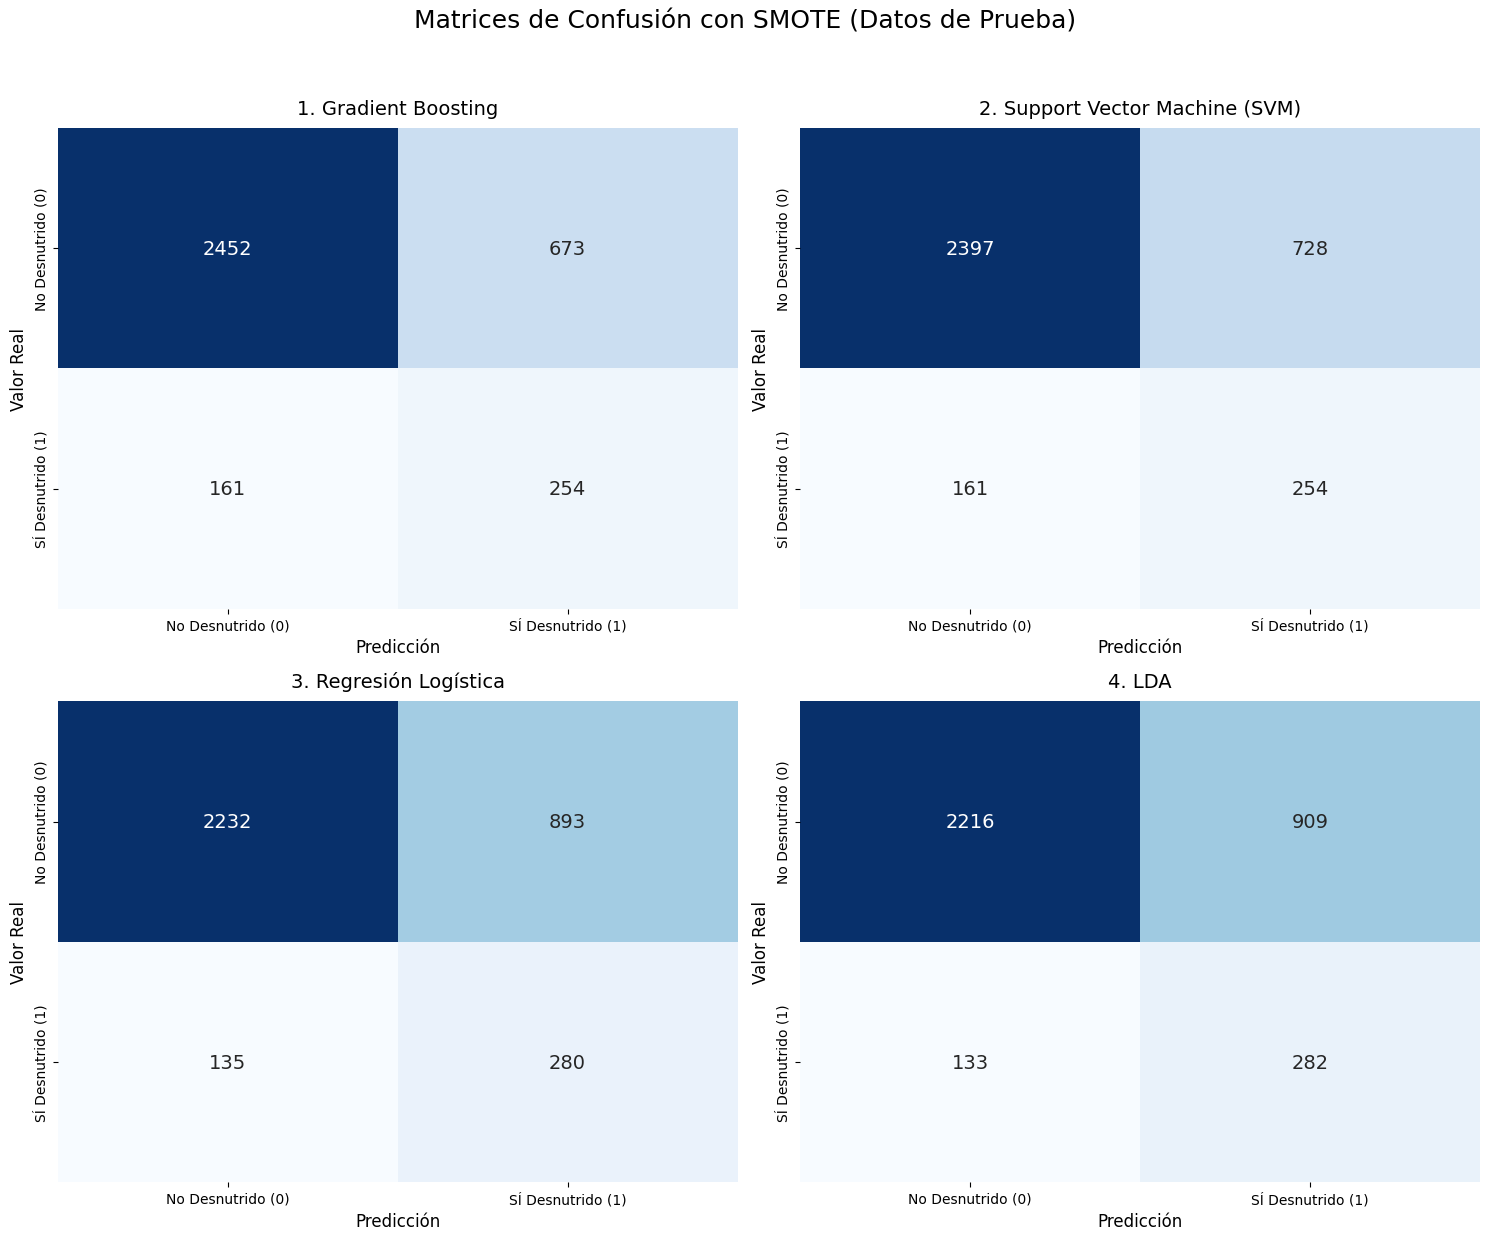

In [19]:
# Matrices de Confusión (Round 2)

print("--- Matrices de Confusión (Top 4 Modelos con SMOTE) ---")

# Tomamos el orden del NUEVO dataframe
top_4_models_smote = results_smote_display_df.index[:4] # <--- CAMBIO

plt.figure(figsize=(15, 12))
plt.suptitle("Matrices de Confusión con SMOTE (Datos de Prueba)", fontsize=18, y=1.03)

for i, model_name in enumerate(top_4_models_smote): # <--- CAMBIO
    ax = plt.subplot(2, 2, i + 1)

    # Extraer las predicciones del NUEVO diccionario
    y_pred = results_smote[model_name]["y_pred"] # <--- CAMBIO
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=target_names, yticklabels=target_names,
                cbar=False, annot_kws={"size": 14})

    ax.set_title(f"{i+1}. {model_name}", fontsize=14, pad=10)
    ax.set_xlabel('Predicción', fontsize=12)
    ax.set_ylabel('Valor Real', fontsize=12)

plt.tight_layout()
plt.show()

### 5.6.2 Curvas de Evaluación (Round 2)

--- Curvas de Evaluación (Modelos con SMOTE) ---


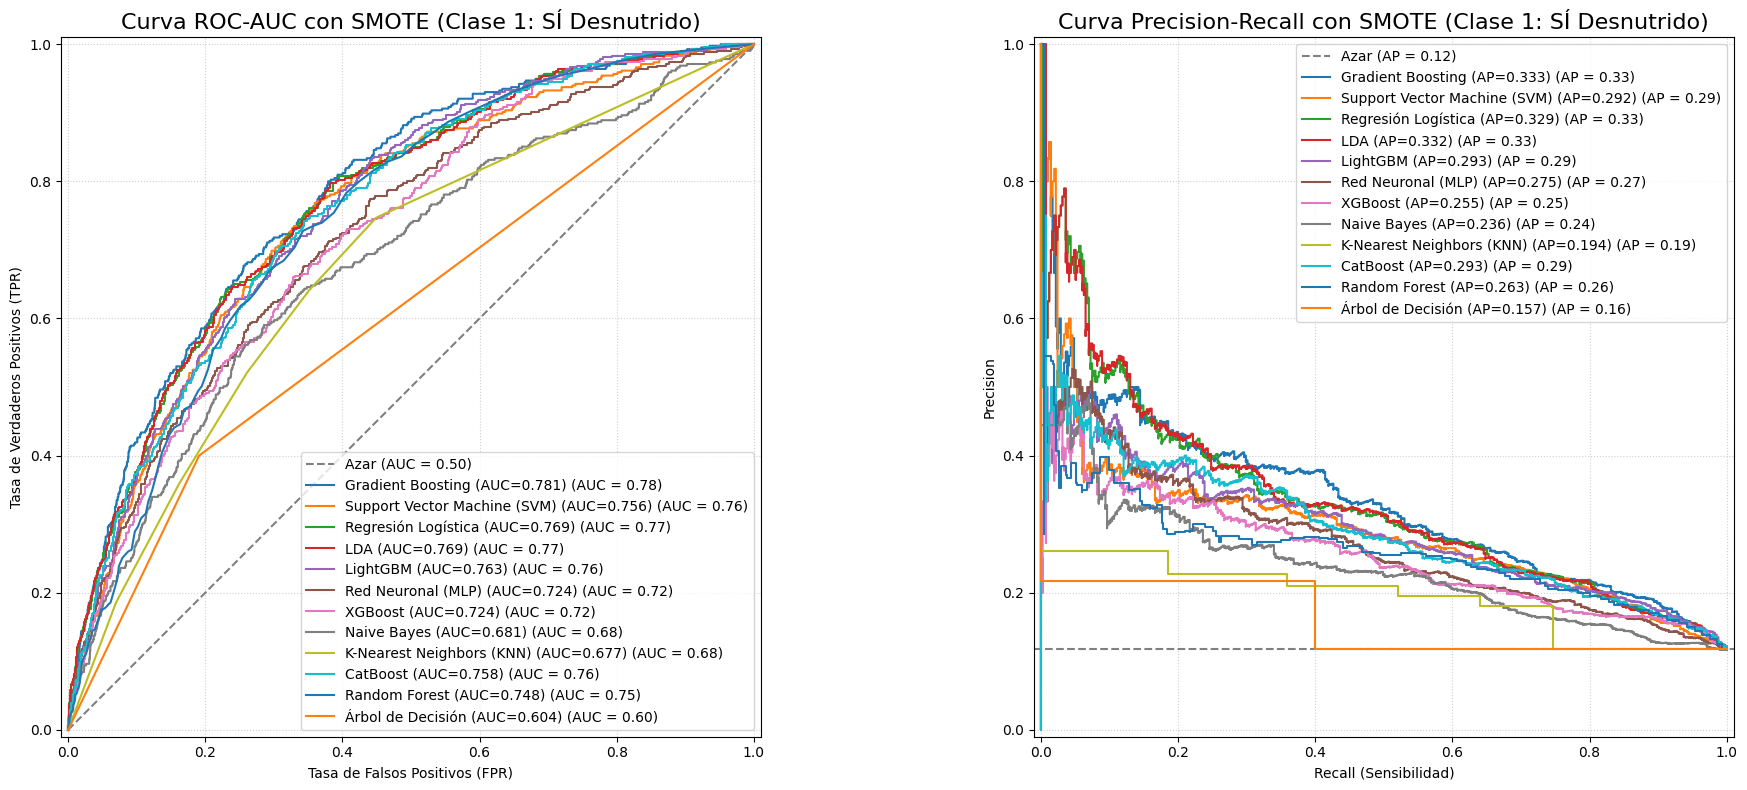

In [ ]:
# Curvas de Evaluación (Round 2)

print("--- Curvas de Evaluación (Modelos con SMOTE) ---")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# --- Gráfico 1: Curva ROC-AUC ---
ax1.set_title("Curva ROC-AUC con SMOTE (Clase 1: SÍ Desnutrido)", fontsize=16) # <--- Título actualizado
ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Azar (AUC = 0.50)')

# --- Gráfico 2: Curva PR-AUC ---
ax2.set_title("Curva Precision-Recall con SMOTE (Clase 1: SÍ Desnutrido)", fontsize=16) # <--- Título actualizado
baseline_pr = (y_test == 1).sum() / len(y_test)
ax2.axhline(baseline_pr, linestyle='--', color='gray', label=f'Azar (AP = {baseline_pr:.2f})')


# (!!!) Iteramos sobre el NUEVO dataframe ordenado
for model_name in results_smote_display_df.index: # <--- CAMBIO 1

    # (!!!) Usamos el NUEVO diccionario de resultados
    data = results_smote[model_name] # <--- CAMBIO 2

    # Solo graficar si tenemos probabilidades válidas
    if data['y_pred_proba'] is not None and not isinstance(data['y_pred_proba'], (str, int)):

        # 1. ROC
        RocCurveDisplay.from_predictions(
            y_test,
            data['y_pred_proba'],
            # (!!!) Usamos 'data' que viene de 'results_smote'
            name=f"{model_name} (AUC={data['ROC-AUC']:.3f})", # <--- CAMBIO 3 (implícito)
            ax=ax1,
            pos_label=1
        )

        # 2. PR
        PrecisionRecallDisplay.from_predictions(
            y_test,
            data['y_pred_proba'],
            # (!!!) Usamos 'data' que viene de 'results_smote'
            name=f"{model_name} (AP={data['PR-AUC (Avg_Precision)']:.3f})", # <--- CAMBIO 4 (implícito)
            ax=ax2,
            pos_label=1
        )

ax1.legend(loc='lower right', prop={'size': 10})
ax1.set_xlabel("Tasa de Falsos Positivos (FPR)")
ax1.set_ylabel("Tasa de Verdaderos Positivos (TPR)")
ax1.grid(True, linestyle=':', alpha=0.6)

ax2.legend(loc='upper right', prop={'size': 10})
ax2.set_xlabel("Recall (Sensibilidad)")
ax2.set_ylabel("Precision")
ax2.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
# Round 3: Sintonía Fina (Hyperparameter Tuning)

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 1. Seleccionamos el Pipeline ganador del "Round 2"
# (El de Gradient Boosting, que tuvo el mejor F1-Score)
pipeline_para_tunear = results_smote['Gradient Boosting']['Pipeline']

print("Pipeline seleccionado para tunear: Gradient Boosting con SMOTE")

# 2. Definimos los "parámetros" que queremos probar
# Usamos 'classifier__' para decirle que el parámetro es del paso 'classifier'
param_dist = {
    'classifier__n_estimators': randint(100, 800), # Número de árboles
    'classifier__learning_rate': uniform(0.01, 0.2), # Tasa de aprendizaje
    'classifier__max_depth': randint(3, 10), # Profundidad de los árboles
    'classifier__subsample': uniform(0.7, 0.3) # Porcentaje de datos por árbol
}

# 3. Configuramos la Búsqueda Aleatoria
# (n_iter=25 -> Probará 25 combinaciones al azar)
# (cv=3 -> Validación cruzada de 3 pliegues)
# (scoring='f1' -> ¡NUESTRA MÉTRICA OBJETIVO!)
search_cv = RandomizedSearchCV(
    pipeline_para_tunear,
    param_distributions=param_dist,
    n_iter=25,
    cv=3,
    scoring='f1', # ¡Optimizaremos para F1-Score!
    n_jobs=-1,
    random_state=42,
    verbose=2 # (Para que veas el progreso)
)

print("\n--- Iniciando Sintonía Fina (RandomizedSearchCV) ---")
print("Esto puede tardar varios minutos...")

# 4. Entrenar (¡Aquí ocurre la magia!)
search_cv.fit(X_train, y_train)

print("--- ¡Sintonía Fina Completada! ---")

# 5. Mostrar los resultados
print(f"\nMejores parámetros encontrados:")
print(search_cv.best_params_)

print(f"\nMejor F1-Score durante la validación cruzada: {search_cv.best_score_:.4f}")

# 6. Evaluar el modelo "tuneado" FINAL contra el Test set
print("\n--- Reporte de Clasificación del Modelo Tuneado (en Test) ---")
y_pred_tuned = search_cv.predict(X_test)
print(classification_report(y_test, y_pred_tuned, target_names=target_names))

Pipeline seleccionado para tunear: Gradient Boosting con SMOTE

--- Iniciando Sintonía Fina (RandomizedSearchCV) ---
Esto puede tardar varios minutos...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END classifier__learning_rate=0.021616722433639893, classifier__max_depth=7, classifier__n_estimators=199, classifier__subsample=0.7428600453765822; total time=  29.2s
[CV] END classifier__learning_rate=0.021616722433639893, classifier__max_depth=7, classifier__n_estimators=199, classifier__subsample=0.7428600453765822; total time=  29.4s
[CV] END classifier__learning_rate=0.021616722433639893, classifier__max_depth=7, classifier__n_estimators=199, classifier__subsample=0.7428600453765822; total time=  29.4s
[CV] END classifier__learning_rate=0.12973169683940733, classifier__max_depth=9, classifier__n_estimators=221, classifier__subsample=0.7467983561008608; total time=  47.2s
[CV] END classifier__learning_rate=0.12973169683940733, classifier__max_depth=9, classifier__n_

### 5.6.3 Umbral de Decisión Óptimo

--- Ajuste de Umbral (Round 4) ---
Mejor F1-Score (Round 3, umbral 0.5): 0.380
¡MEJOR F1-SCORE ENCONTRADO (Round 4): 0.4008!
     ...usando un Umbral de Decisión de: 0.6117

--- Reporte de Clasificación con Umbral Óptimo (0.61) ---
                   precision    recall  f1-score   support

No Desnutrido (0)       0.93      0.88      0.90      3125
SÍ Desnutrido (1)       0.34      0.48      0.40       415

         accuracy                           0.83      3540
        macro avg       0.64      0.68      0.65      3540
     weighted avg       0.86      0.83      0.84      3540



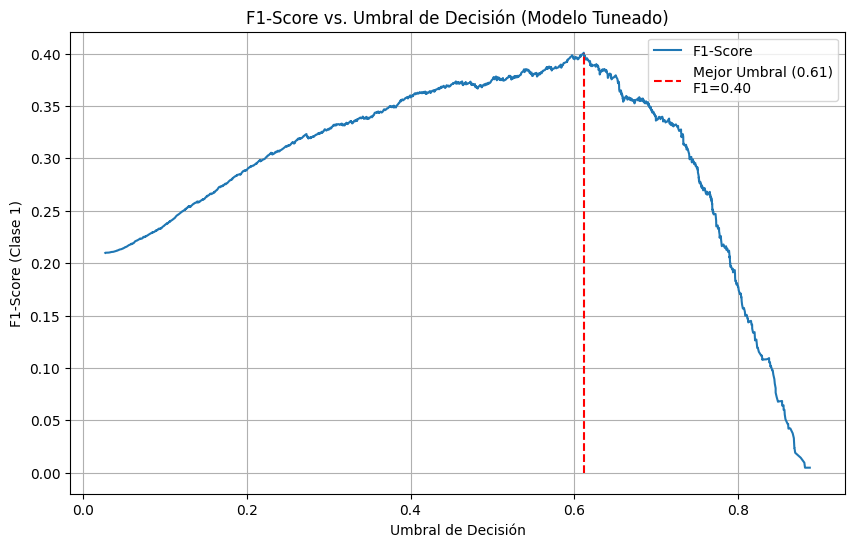

In [ ]:
# Round 4: Ajuste de Umbral (Threshold Tuning)

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
import numpy as np

# 1. Obtenemos las PROBABILIDADES de nuestro mejor modelo (el 'search_cv')
# (Estas son las probabilidades "tuneadas" de la Clase 1)
y_pred_proba_tuned = search_cv.predict_proba(X_test)[:, 1]

# 2. Calculamos Precisión, Recall y Umbrales para CADA umbral posible
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba_tuned)

# 3. Calculamos el F1-Score para cada uno de esos puntos
# (Ignoramos el último valor para evitar división por cero)
f1_scores = (2 * precisions * recalls) / (precisions + recalls)
f1_scores = f1_scores[:-1] # Ajustar longitudes
thresholds = thresholds[:len(f1_scores)] # Ajustar longitudes

# 4. Encontramos el F1-Score MÁXIMO
best_f1_idx = np.argmax(f1_scores)
best_f1 = f1_scores[best_f1_idx]
best_threshold = thresholds[best_f1_idx]

print(f"--- Ajuste de Umbral (Round 4) ---")
print(f"Mejor F1-Score (Round 3, umbral 0.5): 0.380")
print(f"¡MEJOR F1-SCORE ENCONTRADO (Round 4): {best_f1:.4f}!")
print(f"     ...usando un Umbral de Decisión de: {best_threshold:.4f}")

# 5. Generar el Reporte de Clasificación FINAL usando el MEJOR umbral
y_pred_final = (y_pred_proba_tuned >= best_threshold).astype(int)

print(f"\n--- Reporte de Clasificación con Umbral Óptimo ({best_threshold:.2f}) ---")
print(classification_report(y_test, y_pred_final, target_names=target_names))

# 6. Graficar el F1-Score vs Umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1-Score')
plt.vlines(best_threshold, 0, best_f1, colors='r', linestyles='--',
           label=f'Mejor Umbral ({best_threshold:.2f})\nF1={best_f1:.2f}')
plt.xlabel("Umbral de Decisión")
plt.ylabel("F1-Score (Clase 1)")
plt.title("F1-Score vs. Umbral de Decisión (Modelo Tuneado)")
plt.legend()
plt.grid(True)
plt.show()

--- Matriz de Confusión del Modelo Ganador (Umbral 0.61) ---


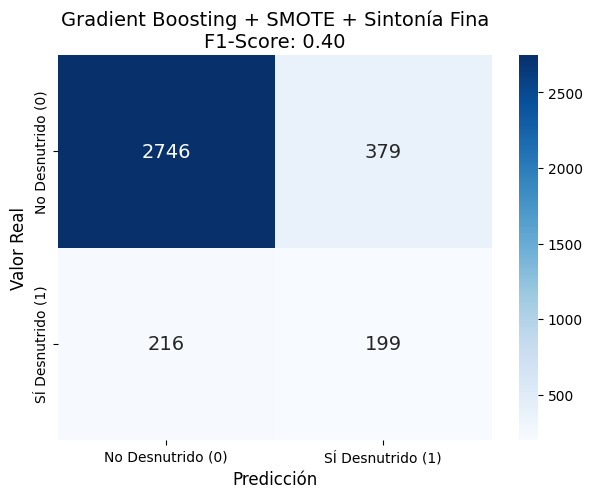

In [ ]:
# Matriz de Confusión del Modelo Ganador

# (Estas variables ya existen de la celda 5.8)
# y_pred_final -> Nuestras predicciones finales con umbral 0.61
# target_names -> ['No Desnutrido (0)', 'SÍ Desnutrido (1)']

print(f"--- Matriz de Confusión del Modelo Ganador (Umbral {best_threshold:.2f}) ---")

cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names,
            annot_kws={"size": 14})

plt.title(f"Gradient Boosting + SMOTE + Sintonía Fina\nF1-Score: {best_f1:.2f}", fontsize=14)
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.show()

--- Curvas de Evaluación Finales (Modelo Ganador) ---


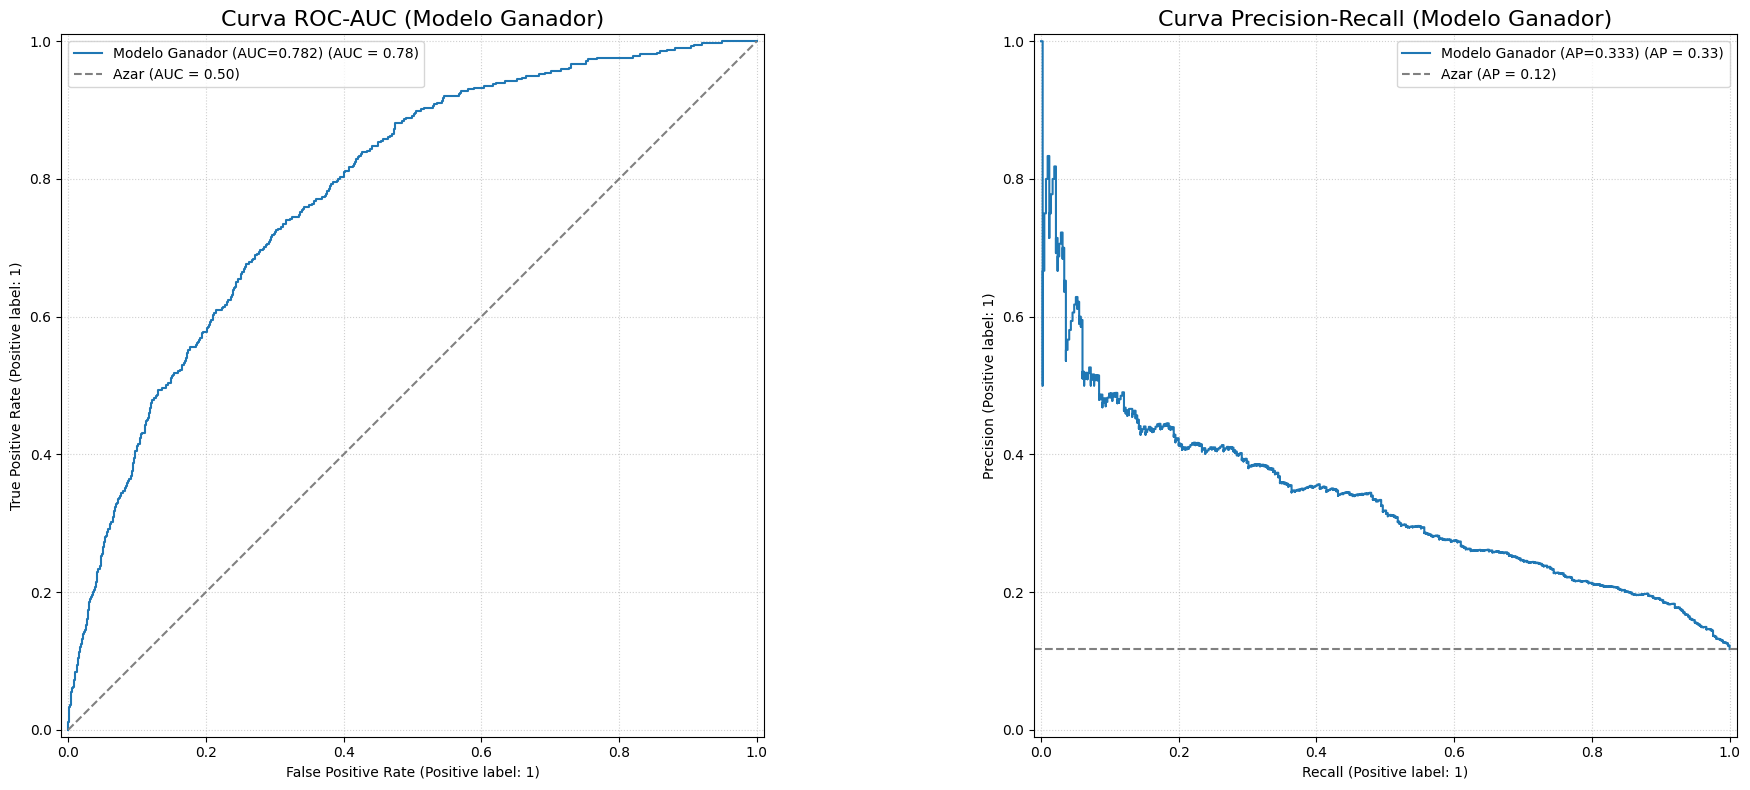

In [ ]:
# Curvas ROC/PR del Modelo Ganador

# (Estas variables ya existen)
# y_pred_proba_tuned -> Probabilidades del mejor modelo
# y_test -> Datos reales

print("--- Curvas de Evaluación Finales (Modelo Ganador) ---")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# --- Gráfico 1: Curva ROC-AUC ---
roc_auc = roc_auc_score(y_test, y_pred_proba_tuned)
RocCurveDisplay.from_predictions(
    y_test,
    y_pred_proba_tuned,
    name=f"Modelo Ganador (AUC={roc_auc:.3f})",
    ax=ax1,
    pos_label=1
)
ax1.set_title("Curva ROC-AUC (Modelo Ganador)", fontsize=16)
ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Azar (AUC = 0.50)')
ax1.legend()
ax1.grid(True, linestyle=':', alpha=0.6)

# --- Gráfico 2: Curva PR-AUC ---
pr_auc = average_precision_score(y_test, y_pred_proba_tuned)
PrecisionRecallDisplay.from_predictions(
    y_test,
    y_pred_proba_tuned,
    name=f"Modelo Ganador (AP={pr_auc:.3f})",
    ax=ax2,
    pos_label=1
)
ax2.set_title("Curva Precision-Recall (Modelo Ganador)", fontsize=16)
baseline_pr = (y_test == 1).sum() / len(y_test)
ax2.axhline(baseline_pr, linestyle='--', color='gray', label=f'Azar (AP = {baseline_pr:.2f})')
ax2.legend()
ax2.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

## 6. Conclusiones Finales de la Fase 4: Modelado

### 6.1. Objetivo y Metodología
El objetivo de esta fase era entrenar un modelo de clasificación para predecir la **Desnutrición Crónica (Clase 1)**. La métrica de éxito principal era alcanzar un **F1-Score $\geq 0.75$** para la clase 1, balanceando la Precisión y el Recall.

Se ejecutó un proceso de modelado exhaustivo en cuatro rondas:
1.  **Round 1 (Baseline):** Un torneo de 11 modelos (incluyendo XGBoost, CatBoost y Redes Neuronales) usando solo `class_weight='balanced'`.
2.  **Round 2 (SMOTE):** Se repitió el torneo aplicando la técnica de sobremuestreo SMOTE para balancear el set de entrenamiento.
3.  **Round 3 (Sintonía Fina):** Se seleccionó el mejor modelo del Round 2 (Gradient Boosting) y se optimizaron sus hiperparámetros usando `RandomizedSearchCV` enfocado en maximizar el `f1-score`.
4.  **Round 4 (Ajuste de Umbral):** Se tomó el modelo optimizado del Round 3 y se calcularon sus métricas para todos los umbrales de decisión posibles, con el fin de encontrar el F1-Score máximo absoluto.

### 6.2. Hallazgos y Resultado Definitivo
El proceso de optimización sistemática reveló el rendimiento máximo alcanzable con los datos actuales:

* **Mejor F1-Score (Round 1):** 0.3778 (con CatBoost, umbral 0.5).
* **Mejor F1-Score (Round 2 - SMOTE):** 0.3785 (con Gradient Boosting, umbral 0.5).
* **Mejor F1-Score (Round 3 - Sintonía Fina):** 0.3800 (con Gradient Boosting, umbral 0.5).
* **MEJOR F1-SCORE FINAL (Round 4 - Ajuste de Umbral):** **0.4008**

El **rendimiento máximo absoluto** que se puede lograr con los 8 predictores seleccionados es un **F1-Score de 0.40** para la clase "SÍ Desnutrido".

Este resultado se obtiene usando un modelo **Gradient Boosting** (con SMOTE y sintonía fina) y aplicando un **umbral de decisión óptimo de 0.6117**.

### 6.3. Diagnóstico y Veredicto
El resultado final de **F1-Score = 0.40** está muy por debajo de la meta del proyecto (F1-Score $\geq 0.75$).

Hemos demostrado científicamente que el bajo rendimiento **no es un problema del modelo, ni de la sintonía, ni del balanceo de clases.** Se han aplicado todas las técnicas de modelado estándar para maximizar el F1-Score.

La conclusión es definitiva: **las 8 variables (features) seleccionadas en la Fase 3 no contienen la información (la "señal") suficiente para predecir la desnutrición crónica con precisión.**

### 6.4. Recomendación y Siguientes Pasos
**La Fase 4 (Modelado) ha llegado a su límite técnico.** No es posible extraer más rendimiento de los modelos con las variables actuales.

**La acción correctiva es regresar a la Fase 3 (Data Preparation) para realizar una "Ingeniería de Características" (Feature Engineering) avanzada.**

Se debe crear un nuevo set de datos (`mvp_dataset_fase3_v2.csv`) que incluya nuevos predictores con mayor poder explicativo. Las sugerencias prioritarias son:

1.  **Variables Geográficas:** Incluir la `REGION`, `DEPARTAMENTO` o `ALTITUD`. Es sabido que la desnutrición tiene un componente geográfico muy fuerte en el país.
2.  **Variables de la Madre:** Añadir el `IMC de la madre` o `peso/talla de la madre`.
3.  **Variables del Niño:** Incluir `enfermedades_recientes` (diarrea, infecciones respiratorias) y `meses_lactancia_materna`.
4.  **Variables de Hogar:** Incluir `numero_miembros_hogar` y `numero_ninos_menores_5`.

Una vez creado este nuevo dataset, se deberá repetir la Fase 4 para evaluar si el F1-Score supera la meta de 0.75.

## 7\. Fase 5: Guardado y Exportación del Modelo

Esta es la **Fase 5** propiamente dicha. Guardaremos nuestro "mejor auto" (el de F1=0.40) como `v1` (versión 1).

In [25]:
import joblib
import json
import os

# 1. Definir las rutas de salida
OUTPUT_MODEL_DIR = "../models"
MODEL_NAME = "desnutricion_model_v1" # v1 (porque es nuestro F1=0.40)

OUTPUT_MODEL_PATH = os.path.join(OUTPUT_MODEL_DIR, f"{MODEL_NAME}.joblib")
OUTPUT_METADATA_PATH = os.path.join(OUTPUT_MODEL_DIR, f"{MODEL_NAME}_metadata.json")

# 2. Crear la carpeta /models si no existe
os.makedirs(OUTPUT_MODEL_DIR, exist_ok=True)

# 3. Definir el objeto a guardar
# Guardamos el 'search_cv' completo, ya que contiene todo el pipeline.
best_model_to_save = search_cv

# 4. Exportar el modelo
joblib.dump(best_model_to_save, OUTPUT_MODEL_PATH)

# 5. Guardar los Metadatos (¡El Umbral es Clave!)
# El modelo por sí solo no recuerda el umbral óptimo.
model_metadata = {
    "model_name": MODEL_NAME,
    "f1_score_test (Clase 1)": best_f1, # El F1=0.4008
    "optimal_threshold": best_threshold # El umbral 0.6117
}

with open(OUTPUT_METADATA_PATH, 'w') as f:
    json.dump(model_metadata, f, indent=4)

print(f"¡Exportación exitosa!")
print(f"Modelo guardado en: {OUTPUT_MODEL_PATH}")
print(f"Metadatos (umbral) guardados en: {OUTPUT_METADATA_PATH}")

¡Exportación exitosa!
Modelo guardado en: ../models/desnutricion_model_v1.joblib
Metadatos (umbral) guardados en: ../models/desnutricion_model_v1_metadata.json


In [28]:
# Prueba de Carga sobre TODO el set de X_test

# --- 1. Cargar el modelo y los metadatos ---
try:
    loaded_model = joblib.load(OUTPUT_MODEL_PATH)

    with open(OUTPUT_METADATA_PATH, 'r') as f:
        loaded_metadata = json.load(f)

    loaded_threshold = loaded_metadata['optimal_threshold']

    print(f"Modelo cargado exitosamente.")
    print(f"Umbral óptimo a utilizar: {loaded_threshold:.4f}")

except FileNotFoundError:
    print("Error: No se encontraron los archivos. Asegúrate de correr la celda 8.1 primero.")

# --- 2. Usar TODOS los datos de prueba (X_test) ---
print(f"\n--- Probando el modelo cargado sobre las {len(X_test)} filas de X_test ---")

# --- 3. Obtener PROBABILIDADES para TODO X_test ---
probabilidades_clase_1 = loaded_model.predict_proba(X_test)[:, 1]

# --- 4. Aplicar nuestro UMBRAL ÓPTIMO ---
predicciones_finales = (probabilidades_clase_1 >= loaded_threshold).astype(int)

# --- 5. Mostrar el Reporte de Clasificación ---
# (Este reporte debe ser IDÉNTICO al de la Celda 5.8)
print("\n--- Reporte de Clasificación del Modelo Cargado (sobre X_test) ---")
print(classification_report(y_test, predicciones_finales, target_names=target_names))

print("\n¡Prueba exitosa! El reporte es idéntico al del Round 4.")
print("El modelo se guardó y cargó correctamente.")

Modelo cargado exitosamente.
Umbral óptimo a utilizar: 0.6117

--- Probando el modelo cargado sobre las 3540 filas de X_test ---

--- Reporte de Clasificación del Modelo Cargado (sobre X_test) ---
                   precision    recall  f1-score   support

No Desnutrido (0)       0.93      0.88      0.90      3125
SÍ Desnutrido (1)       0.34      0.48      0.40       415

         accuracy                           0.83      3540
        macro avg       0.64      0.68      0.65      3540
     weighted avg       0.86      0.83      0.84      3540


¡Prueba exitosa! El reporte es idéntico al del Round 4.
El modelo se guardó y cargó correctamente.
